# Create an efficient frontier for a portfolio 

In [1]:
import warnings
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import numpy as np
import yfinance as yf
import pandas_datareader.data as web
from numpy.random import random, uniform, dirichlet, choice

## Prepare data

In [2]:
#Pick several companies as our portfolio
tickers = ['AAPL', 'MSFT', 'META']
dfs = []

# Download daily price data for each ticker
for ticker in tickers:
    temp = yf.download(ticker, start='2018-01-01', end='2022-12-31')
    temp.columns = pd.MultiIndex.from_product([[ticker], temp.columns])
    dfs.append(temp)


df = pd.concat(dfs, axis=1)
print(df.head(5))
df.info()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
                 AAPL                                                         \
                 Open       High        Low      Close  Adj Close     Volume   
Date                                                                           
2018-01-02  42.540001  43.075001  42.314999  43.064999  40.670979  102223600   
2018-01-03  43.132500  43.637501  42.990002  43.057499  40.663895  118071600   
2018-01-04  43.134998  43.367500  43.020000  43.257500  40.852776   89738400   
2018-01-05  43.360001  43.842499  43.262501  43.750000  41.317905   94640000   
2018-01-08  43.587502  43.902500  43.482498  43.587502  41.164440   82271200   

                 MSFT                                                        \
                 Open       High        Low      Close  Adj Close    Volu

In order to calculate the efficient frontier, we need use the risk-free rate, which can be acquired by the 10-year treasury bond return, asset return, standard deviation, and covariance matrix.

## Download risk free rate by treasury bond and data clean

In [3]:
#df['AAPL', "Adj Close"]
#download 10-year treasury rate
rf = web.DataReader('DGS10', 'fred', '2018-01-01', '2022-12-31').squeeze()
rf = rf.mean()
rf = rf/100 #convert to decimal

In [4]:
df_ac = pd.DataFrame()
for ticker in tickers:
    temp = df[ticker,'Adj Close']
    temp.name = ticker
    df_ac = pd.concat([df_ac, temp],axis = 1)
    
#Get the daily return and drop na
ret = df_ac.pct_change(1).dropna()
ret.head(5)

,AAPL,MSFT,META
2018-01-03 00:00:00,-0.000174,0.004654,0.017914
2018-01-04 00:00:00,0.004645,0.008802,-0.001841
2018-01-05 00:00:00,0.011386,0.012398,0.013671
2018-01-08 00:00:00,-0.003714,0.001020,0.007653
2018-01-09 00:00:00,-0.000115,-0.000680,-0.002178


In [5]:
ret_mean = ret.mean()
ret_cov = ret.cov()
ret_cov

,AAPL,MSFT,META
AAPL,0.000445,0.000319,0.000336
MSFT,0.000319,0.000382,0.000331
META,0.000336,0.000331,0.000742


## Build up the portfolio 

To generate a diversified portfolio as well as a densed portfolio at the same time, using Dirchlet Distribution is a great way to approach.
This is a distribution on the Simplex: 
$$S = \{x \in \mathbb{R}^n | \sum_i x_i = 1, x_i \geq 0\}$$

In [6]:
#create a dirchlet distribution
alpha = [0.5, 0.5, 0.5]
#create a 10000 random portfolio
weights = dirichlet(alpha=alpha, size=10000)
weights


df_w= pd.DataFrame(weights, index = range(10000))

#rename the column
new_column_names = ['w_AAPL', 'w_MSFT', 'w_META']
df_w.columns = new_column_names

print(df_w)
#calculate return for each random portfolio
ret_p = weights @ ret_mean.values + 1

#calculate standard deviation for each random portfolio
std = (weights @ ret.T).std(1)

#convert to annual return and standard deviation to calculate sharpe ratio

ret_pa = ret_p ** 252 - 1
std_a = std * np.sqrt(252)

sr = (ret_pa - rf)/std_a

#create a dataframe to store elements

df_port = pd.DataFrame({'STD annual': std_a,
              'RET annual': ret_pa,
              'SR': sr})

df_port = pd.concat([df_port, df_w], axis = 1)

df_port

        w_AAPL    w_MSFT    w_META
0     0.588824  0.056877  0.354300
1     0.032597  0.001613  0.965790
2     0.491166  0.075948  0.432886
3     0.726946  0.000878  0.272176
4     0.030986  0.863685  0.105329
...        ...       ...       ...
9995  0.135140  0.821616  0.043244
9996  0.165328  0.549768  0.284904
9997  0.115257  0.001490  0.883253
9998  0.517902  0.307623  0.174474
9999  0.216839  0.782790  0.000370

[10000 rows x 3 columns]


,STD annual,RET annual,SR,w_AAPL,w_MSFT,w_META
0,0.326649,0.208464,0.574971,0.588824,0.056877,0.354300
1,0.424308,0.023808,0.007443,0.032597,0.001613,0.965790
2,0.331804,0.182321,0.487250,0.491166,0.075948,0.432886
3,0.326689,0.237362,0.663358,0.726946,0.000878,0.272176
4,0.306699,0.271108,0.816623,0.030986,0.863685,0.105329
...,...,...,...,...,...,...
9995,0.303593,0.294009,0.900414,0.135140,0.821616,0.043244
9996,0.309956,0.218532,0.638418,0.165328,0.549768,0.284904
9997,0.405913,0.047160,0.065309,0.115257,0.001490,0.883253
9998,0.307778,0.262416,0.785520,0.517902,0.307623,0.174474


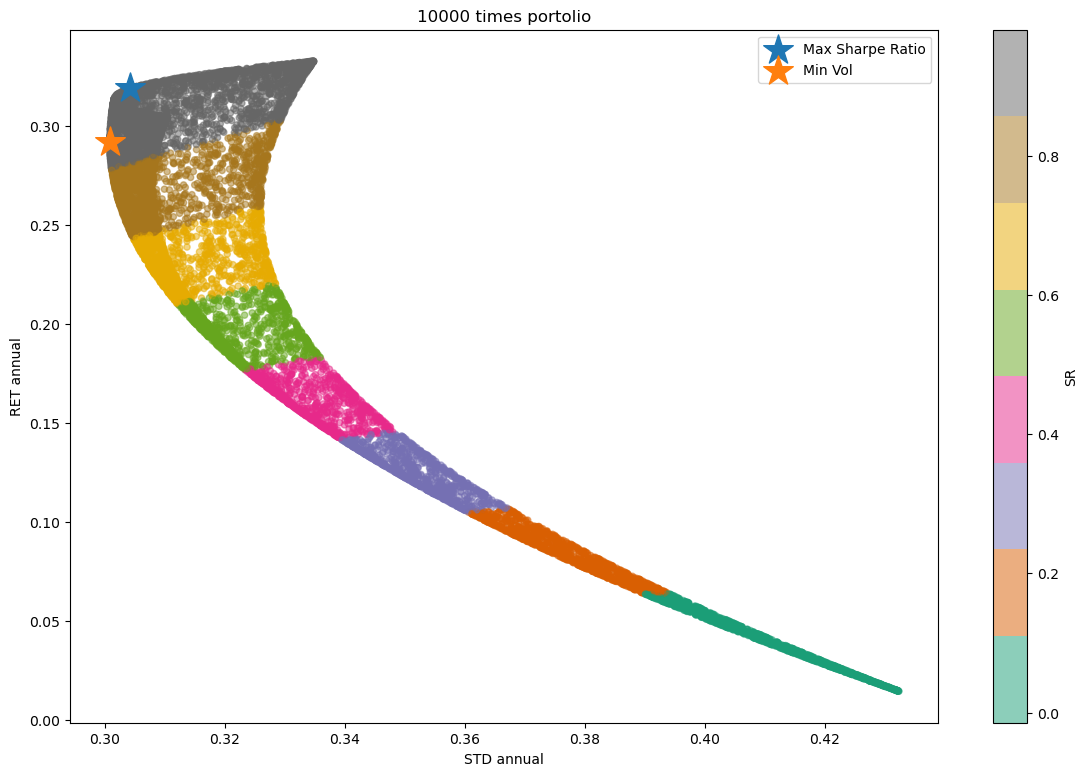

In [7]:
#plot the portfolio and present the max SR and min Vol
import matplotlib.pyplot as plt
pp = df_port.plot.scatter(x=0, y=1, c=2, cmap='Dark2',
                         alpha=0.5, figsize=(14, 9), colorbar=True,
                         title= '10000 times portolio')
mx = df_port['SR'].idxmax()
df_port.iloc[mx, :]

pp.scatter(df_port['STD annual'].iloc[mx], df_port['RET annual'].iloc[mx], marker='*', s=500, label='Max Sharpe Ratio')

mn = df_port['STD annual'].idxmin()
pp.scatter(df_port['STD annual'].iloc[mn], df_port['RET annual'].iloc[mn], marker='*', s=500, label='Min Vol')

plt.legend(loc='best')